# Modeling: Aspect-Based Sentiment Analysis (Aspect Extraction)
## BerTweet 
*Building a multi-label classifier for ABSA using a BERTweet model*

**`Overview:`** 

As seen mentioned by [(Karimi et al., 2021)](https://arxiv.org/pdf/2001.11316.pdf), aspect-based sentiment analysis (ABSA) can be broken down into two subtasks of *aspect extraction (AE)* and *aspect sentiment classification (ASC)* (Hu and Liu, 2004). This notebook focuses on the first subtask of aspect extraction.
\
\
Here ABSA is framed as a multi-label classification problem and a BERTweet model is fine-tuned to learn and predict the predetermined aspects (price, speed, coverage, customer service, and reliability) for our Nigerian Internet Service domain.

**`Initial results:`** 


Initial results indicate poor extraction performance of the fine-tuned model. This might be as a result of limited data. I look towards a binary relevance approach (using a set of independent classifier which each predict a different aspect) for the same multi-label classification problem in 6.2.2

## 1. Library Importation

In [28]:
#Data manipulation and visualization packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling packages
import torch
from tqdm.auto import tqdm
import pytorch_lightning as pl
from torchmetrics import Precision, Recall, FBeta, AUROC
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel

#Model evaluation and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

#Set seed
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)

Global seed set to 123


123

## 2. Loading the data

In [4]:
#Load the dataframe with punctuated tweets. 
aspect_df = pd.read_csv("../data/processed/absa_text_annotated_price.csv")

#Load the dataframe from the 2nd absa annotation phase
#- Contains mostly tweets with aspect annotation (unlike the dataframe above)
aspect_df2 = pd.read_csv("../data/processed/second_tweet_absa_annotated.csv")

print(f"aspect_df size: {aspect_df.shape}")
print(f"aspect_df2 size: {aspect_df2.shape}")

aspect_df size: (377, 3)
aspect_df2 size: (111, 4)


In [5]:
#Merge both dataframes together
merged_absa_df = pd.concat([aspect_df,aspect_df2.drop(columns = ['Cleaned tweets'])])
print(merged_absa_df.shape)
merged_absa_df.head()

(488, 3)


,Text,Aspects,Sentiment
0,my family used my spectranet and they don't wa...,NaN,NaN
1,spectranet_ng how can i get the freedom mifi i...,NaN,NaN
2,drolufunmilayo iconic_remi spectranet_ng,NaN,NaN
3,spectranet_ng your response just proves how ho...,['customer service'],['Negative']
4,"spectranet is just the worse tbh, i can't even...",['speed'],['Negative']


## 3. Reformat the data

### a. Convert lists from string format to list

In [6]:
#Convert Aspects column
merged_absa_df.Aspects = merged_absa_df.Aspects.apply(lambda x: eval(x) if (pd.notnull(x)) else x)

#Convert Sentiment column
merged_absa_df.Sentiment = merged_absa_df.Sentiment.apply(lambda x: eval(x) if (pd.notnull(x)) else x)

#Make a copy of the dataframe
processed_aspect_df = merged_absa_df.copy()

#Quick preview
processed_aspect_df.head()

,Text,Aspects,Sentiment
0,my family used my spectranet and they don't wa...,NaN,NaN
1,spectranet_ng how can i get the freedom mifi i...,NaN,NaN
2,drolufunmilayo iconic_remi spectranet_ng,NaN,NaN
3,spectranet_ng your response just proves how ho...,[customer service],[Negative]
4,"spectranet is just the worse tbh, i can't even...",[speed],[Negative]


### b. Fill NaNs with [None]

In [7]:
processed_aspect_df = processed_aspect_df.apply(lambda s: s.fillna({i: [None] for i in processed_aspect_df.index}))
processed_aspect_df.head()

,Text,Aspects,Sentiment
0,my family used my spectranet and they don't wa...,[None],[None]
1,spectranet_ng how can i get the freedom mifi i...,[None],[None]
2,drolufunmilayo iconic_remi spectranet_ng,[None],[None]
3,spectranet_ng your response just proves how ho...,[customer service],[Negative]
4,"spectranet is just the worse tbh, i can't even...",[speed],[Negative]


### c. Binarizing the aspects

In [8]:
#List aspects determined during the annotation phase
#Note: This might not be exhaustive! But it should cover most cases. It is also subjective!
#Also using synonyms of these words will likely yield different results
ASPECTS = ['price','speed','reliability','coverage', 'customer service']

#Iterate through all the aspects and if the aspect is not in the tweet, record 0 else record 1
for aspect in ASPECTS[::-1]:
    processed_aspect_df.insert(1,aspect,processed_aspect_df.Aspects.apply(lambda x: 1 if aspect in x else 0))
    
#Drop the Aspects column
processed_aspect_df.drop(columns=['Aspects'] , inplace=True)

#Quick preview
processed_aspect_df.head()

,Text,price,speed,reliability,coverage,customer service,Sentiment
0,my family used my spectranet and they don't wa...,0,0,0,0,0,[None]
1,spectranet_ng how can i get the freedom mifi i...,0,0,0,0,0,[None]
2,drolufunmilayo iconic_remi spectranet_ng,0,0,0,0,0,[None]
3,spectranet_ng your response just proves how ho...,0,0,0,0,1,[Negative]
4,"spectranet is just the worse tbh, i can't even...",0,1,0,0,0,[Negative]


In [9]:
#Save the binarized dataframe
processed_aspect_df.to_csv("../data/processed/absa_binarized.csv",index=False)

## 4. Quick EDA

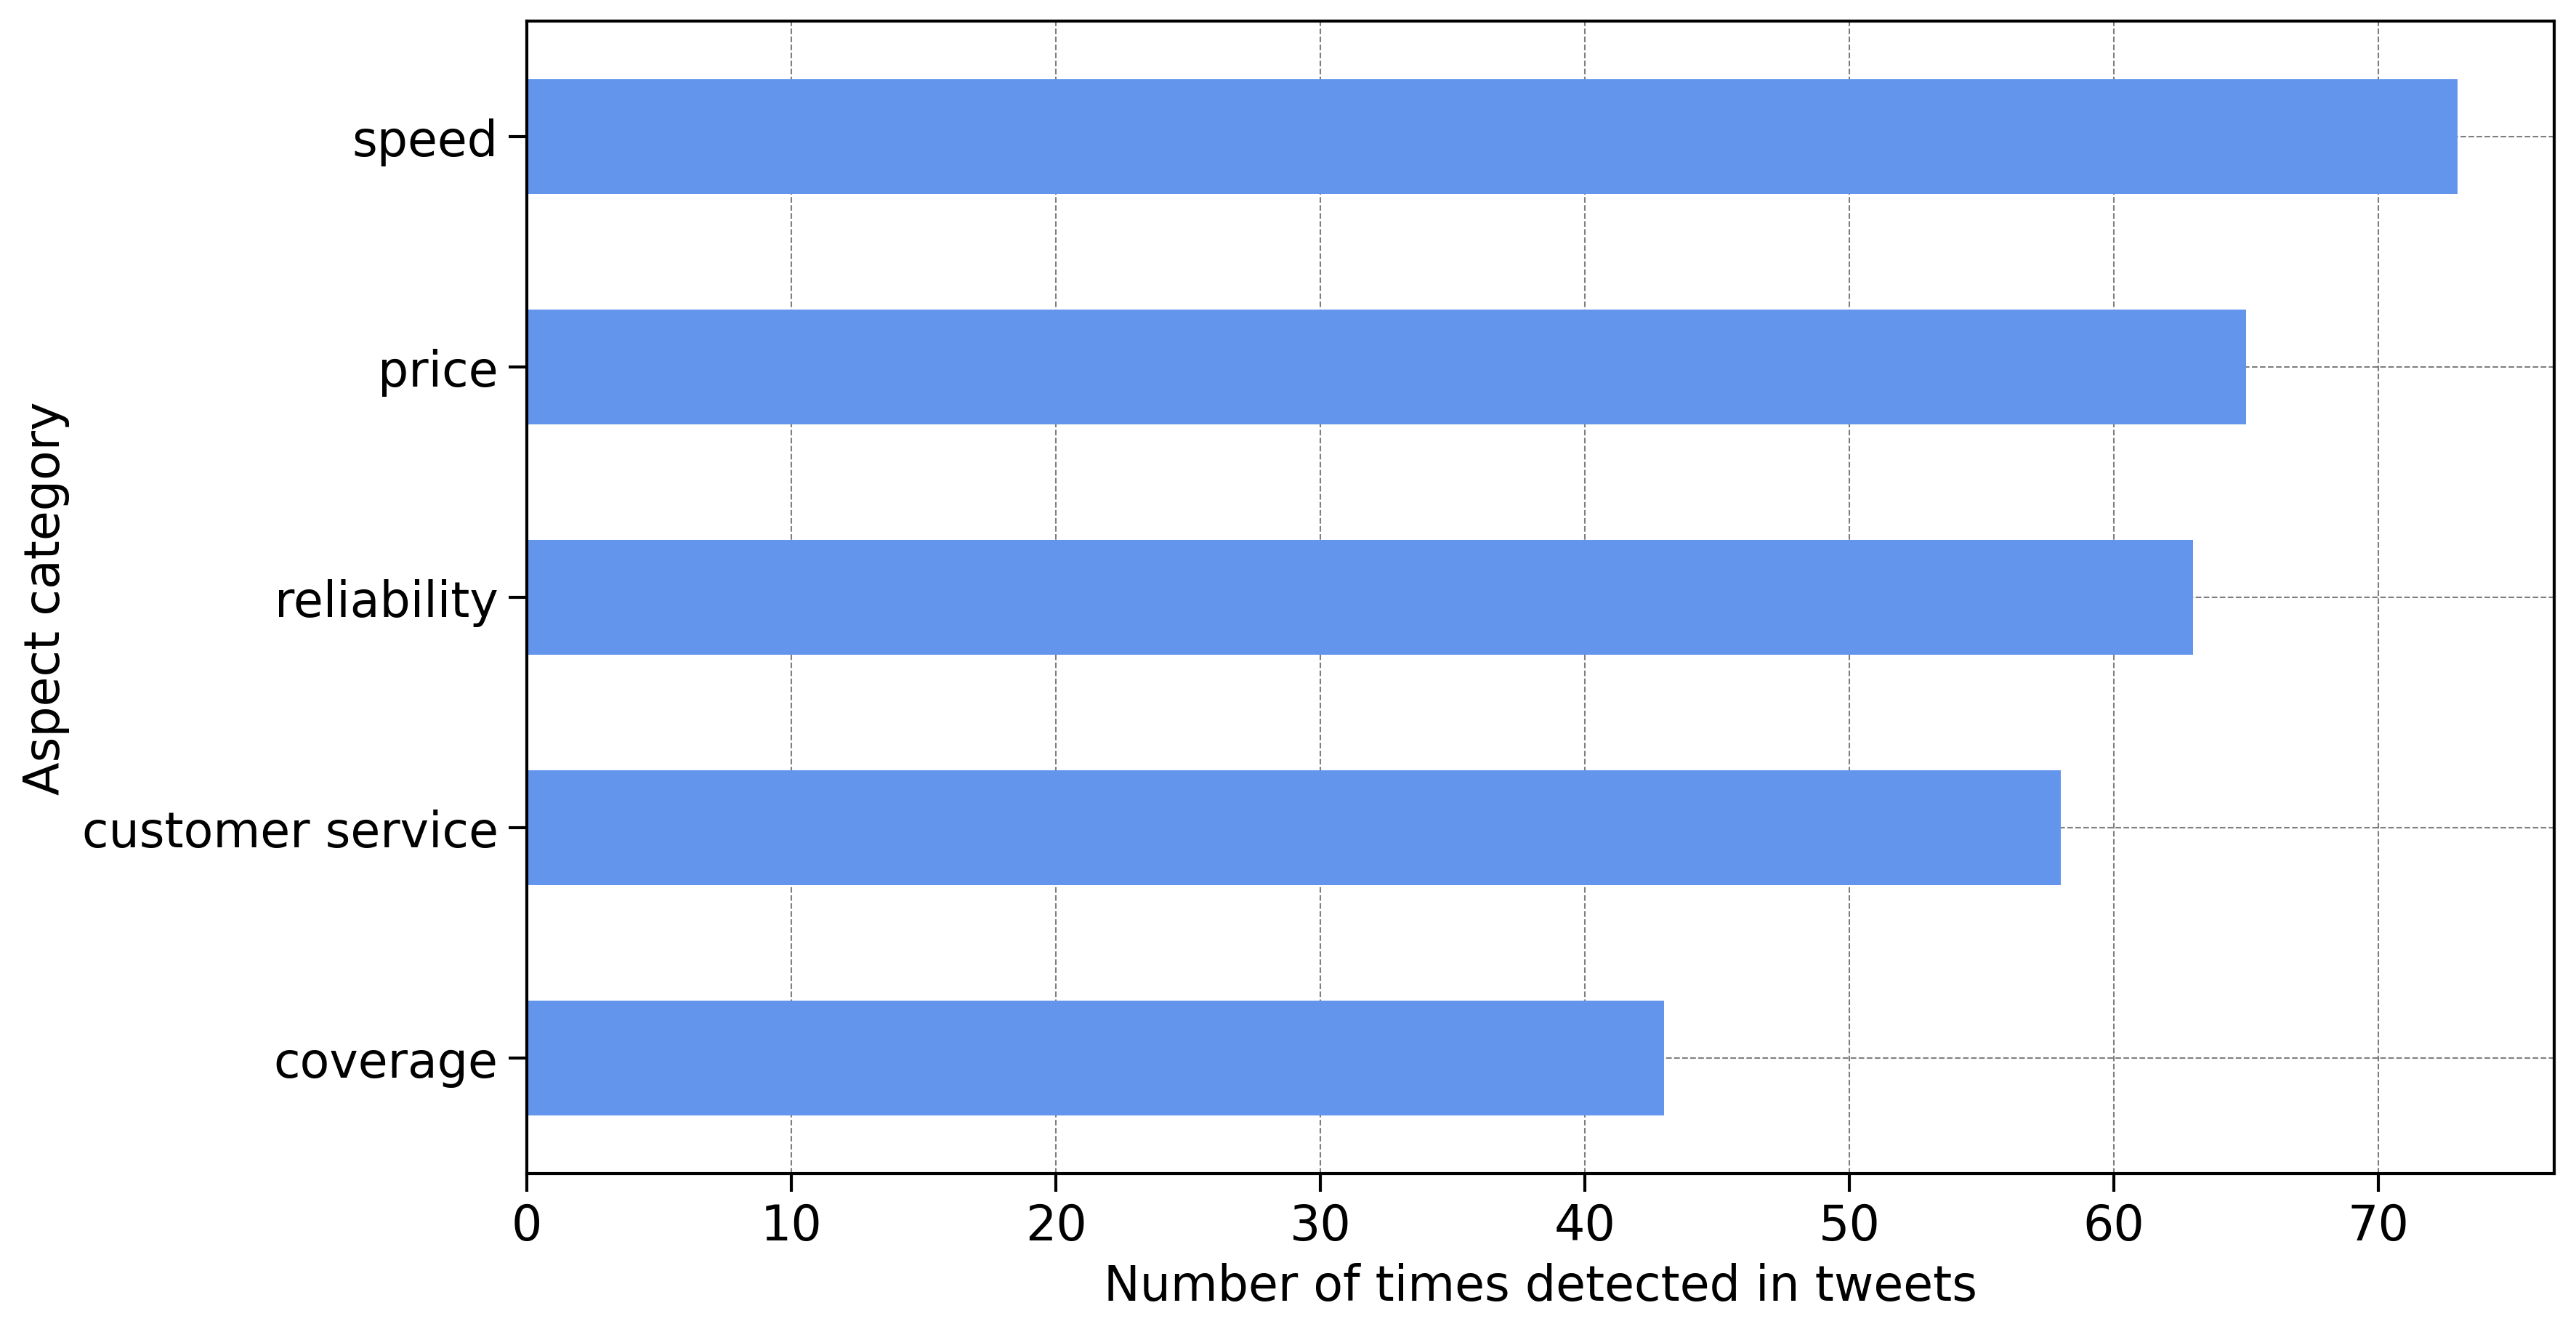

In [10]:
with plt.style.context(['notebook','no-latex','grid']):
    plt.figure(figsize = (12,7), dpi=300)
    processed_aspect_df[ASPECTS].sum().sort_values()\
                                            .plot(kind = "barh", color = 'cornflowerblue')\
                                            .set(xlabel = "Number of times detected in tweets",
                                                ylabel = "Aspect category")
                        
    plt.show()

From the above, we see that the labels are quite imbalanced. Trustworthiness is especially important to point out. To account for this, we look into reweighting our loss function. However, before doing so, we look more broadly into aspects vs no aspects tweets distribution:

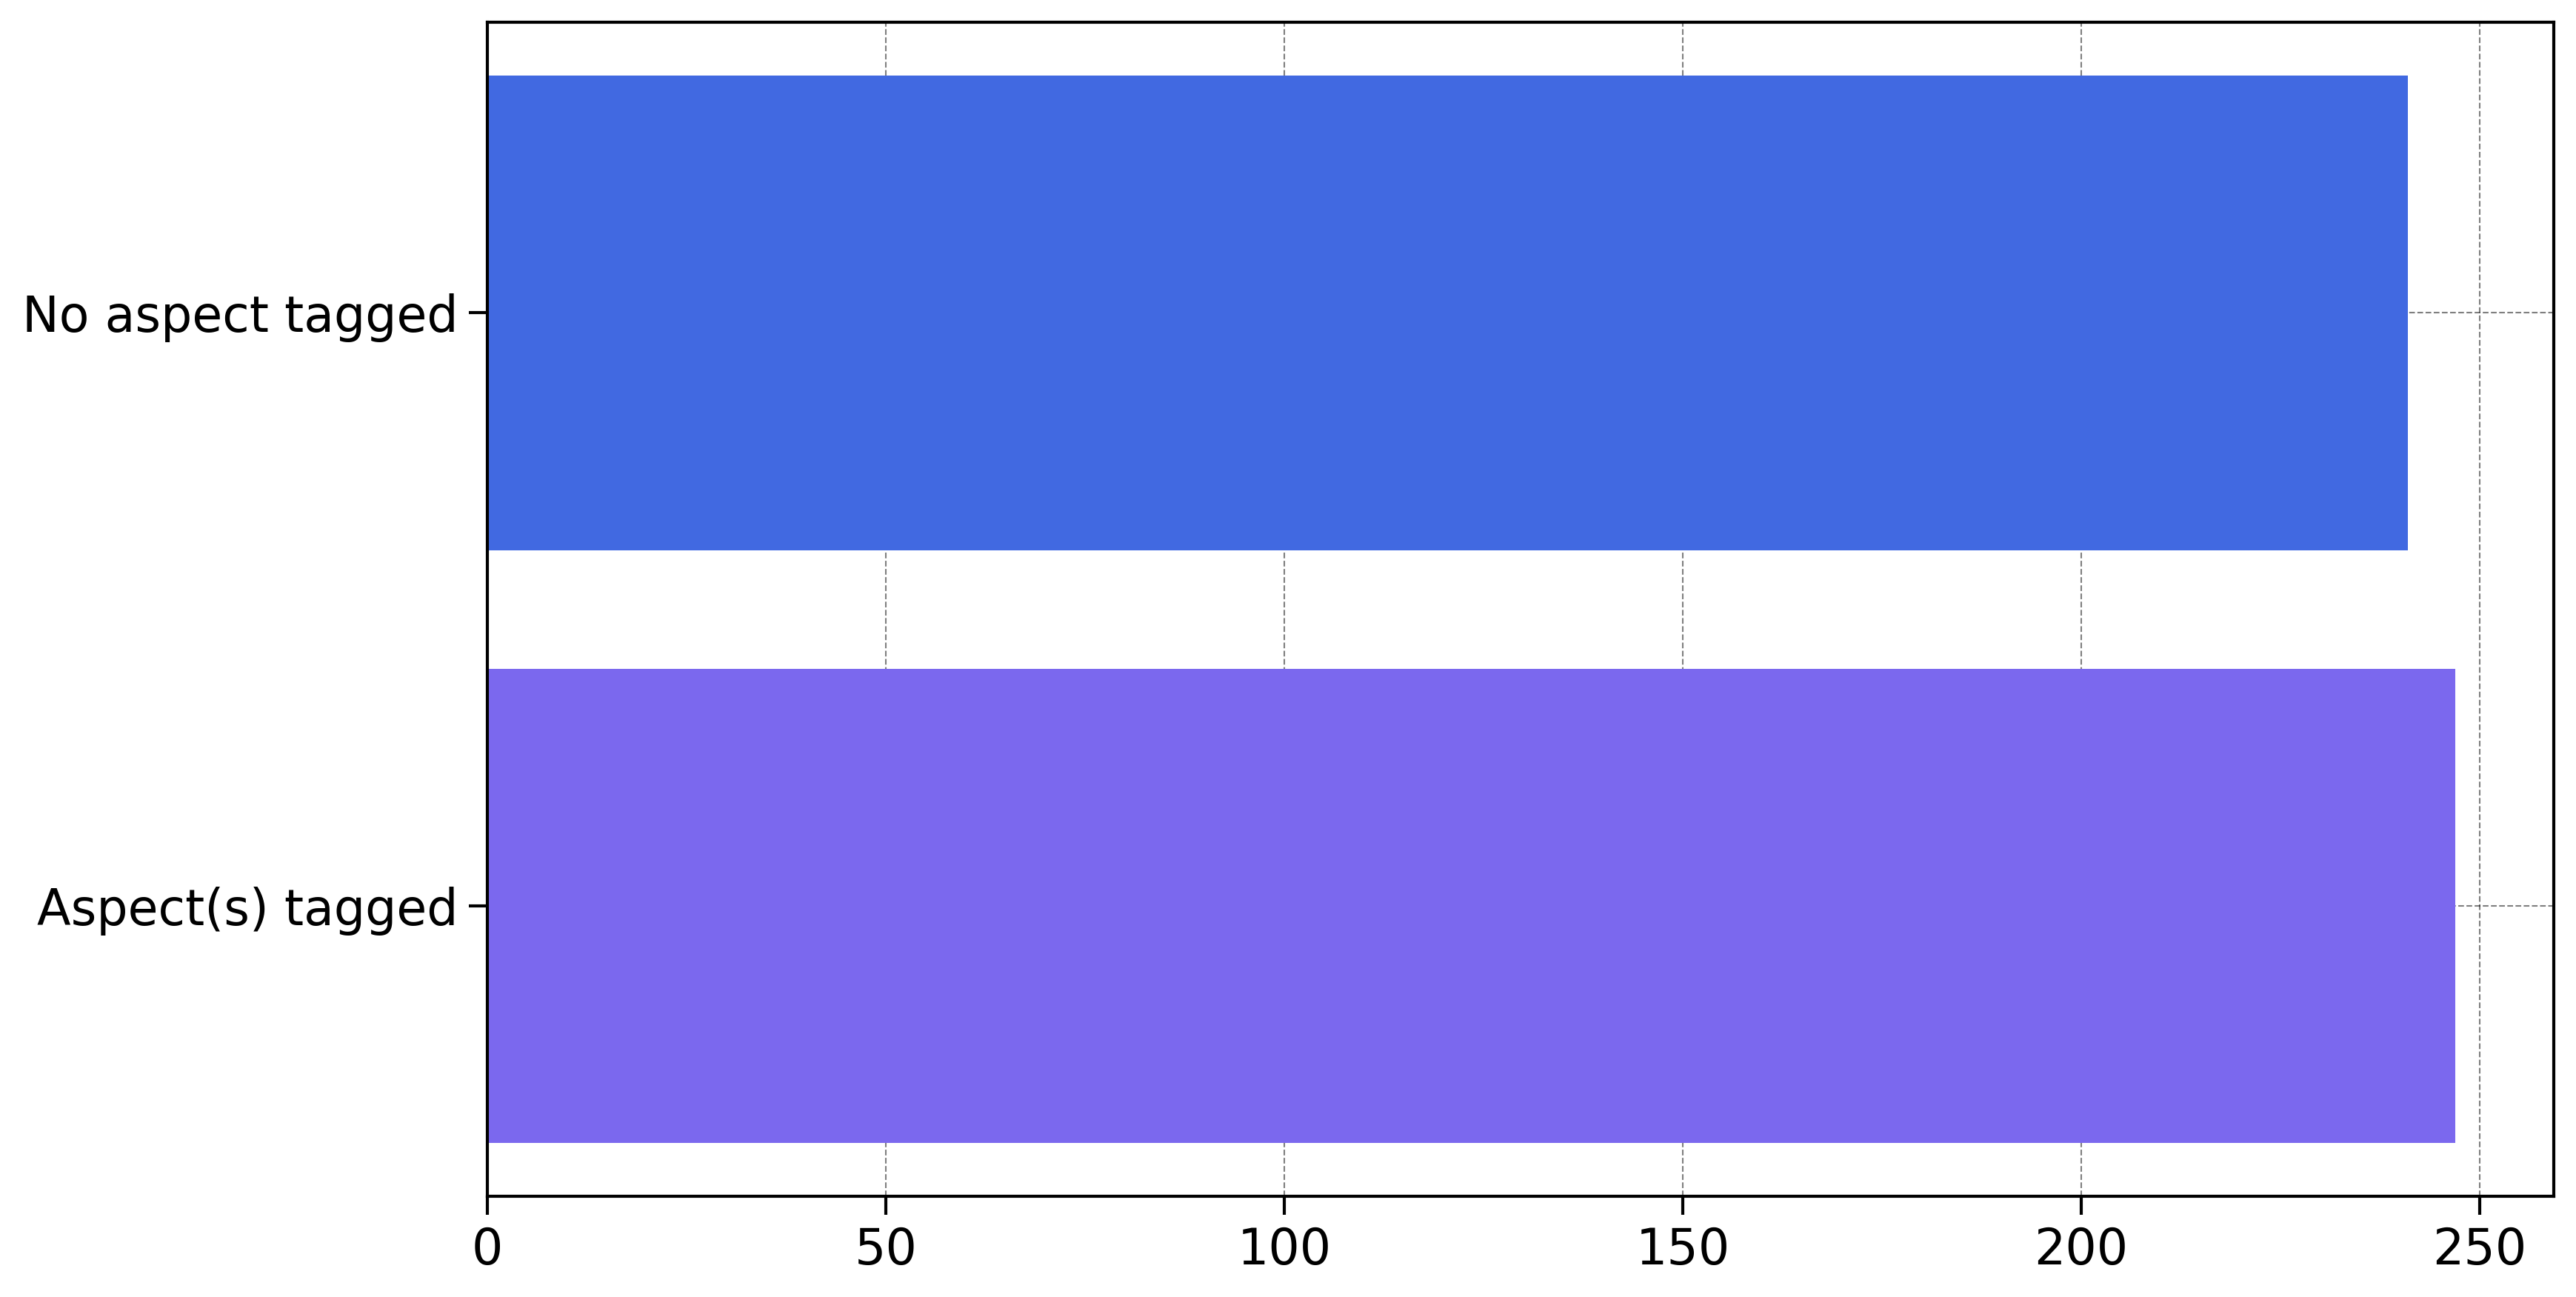

In [11]:
#Get the rows with aspects tagged and no aspects tagged
aspects_tagged = processed_aspect_df[processed_aspect_df[ASPECTS].sum(axis=1) > 0]
no_aspects_tagged = processed_aspect_df[processed_aspect_df[ASPECTS].sum(axis=1) == 0]

with plt.style.context(['notebook','no-latex','grid']):
    plt.figure(figsize = (12,7), dpi=300)
    plt.barh(['Aspect(s) tagged','No aspect tagged'],
             [len(aspects_tagged),len(no_aspects_tagged)],color=['mediumslateblue','royalblue'])

Roughly balanced.

## 5. Split data into training, validation and test set

### a. Split to training and test set

In [12]:
#Split the data 80:20 (training and test)
train_df, test_df = train_test_split(processed_aspect_df,test_size=0.20,
                                    stratify = processed_aspect_df.coverage)
print(f"Train size: {train_df.shape}", f"Test size: {test_df.shape}")

Train size: (390, 7) Test size: (98, 7)


### b. Split training set to training and validation set

In [13]:
train_df, val_df = train_test_split(train_df,test_size=0.25,
                                    stratify = train_df.coverage)
print(f"Train size: {train_df.shape}", f"Validation size: {val_df.shape}")

Train size: (292, 7) Validation size: (98, 7)


### c. Check to see that all the sets have all the aspect categories

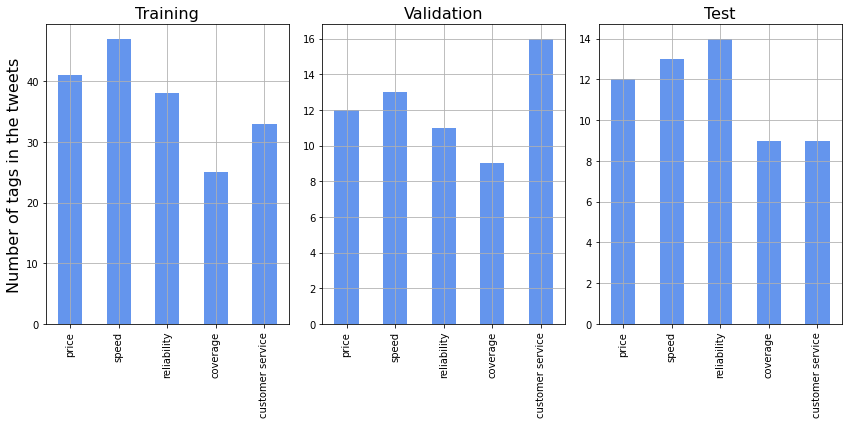

In [14]:
df_sets = [('Training',train_df),('Validation', val_df),('Test',test_df)]
    
plt.figure(figsize = (12,6))
for idx,df in enumerate(df_sets):
    
    plt.subplot(1,3,idx+1)
    plt.tight_layout()

    with plt.style.context(['notebook','no-latex','grid']):
        
        plt.title(df[0])
        df[1][ASPECTS].sum().plot(kind = "bar", color = 'cornflowerblue')
        plt.xticks(rotation=90)
        
        if idx == 0:
            plt.ylabel('Number of tags in the tweets', fontsize=16)
        
    
plt.show()
        

## 6. Modeling - Aspect Extraction v1
**`Default BCE Loss Function`**

Dataset from above has been changed so the below section won't reproduce the results if reran!

### a. Load the tokenizer and the BERTweet model

In [15]:
#Load BerTweet tokenizer
TOKENIZER = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)

#Load the BERTweet model
BERTWEET_MODEL = AutoModel.from_pretrained("vinai/bertweet-base", from_tf = True, return_dict = True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
2021-12-10 12:09:39.471568: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All TF 2.0 model weights were used when initializing RobertaModel.

All the weights of RobertaModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaModel for predictions without further training.


### b. Prepare the training, validation, and test sets

In [16]:
TRAIN_BATCH_SIZE = 32 #Increase batch size so the model has an increased chance of seeing as many aspects
TEST_BATCH_SIZE = 8

In [17]:
class Generate_PyTorch_Dataset(torch.utils.data.Dataset):

    def __init__(self, dataframe, tokenizer):
        self.dataframe  = dataframe
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.dataframe)
  
    def __getitem__(self, idx):
        
        #Get each row of the dataframe
        data_row = self.dataframe.iloc[idx]
        
        #Get the tweet
        text = str(data_row.Text)
        
        #Get the aspect labels
        labels = data_row[ASPECTS]
        
        #Encode the tweet
        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens    = True,
            truncation            = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            return_length         = True,
            max_length            = self.max_len,
            return_tensors        = 'pt',
            padding               = "max_length"
        )
        
        
        return {
            'input_ids': encoded_text['input_ids'].flatten(),
            'attention_mask': encoded_text['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }
    

In [18]:
class PyTorchDataModule(pl.LightningDataModule):
    
    def __init__(self, train_df, val_df, test_df, tokenizer, train_batch_size=16, test_batch_size=8):
        
        super().__init__()
        self.train_df = train_df
        self.val_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.max_len = self.tokenizer.model_max_length
        
    def setup(self):
        
        """
        Setup the training, validation and test sets by converting them to Pytorch datasets
        """
        
        self.train_dataset = Generate_PyTorch_Dataset(self.train_df,self.tokenizer)
        self.val_dataset = Generate_PyTorch_Dataset(self.val_df,self.tokenizer)
        self.test_dataset = Generate_PyTorch_Dataset(self.test_df,self.tokenizer)
        
        
    def train_dataloader(self):
        
        """
        Training set dataloader
        """
        
        return DataLoader(self.train_dataset,
                          batch_size  = self.train_batch_size,
                          shuffle     = True, 
                          num_workers = 2)
         
    def val_dataloader(self):
        
        """
        Validation set dataloader
        """
        
        return DataLoader(self.val_dataset, batch_size = self.test_batch_size, num_workers=2)
        
    def test_dataloader(self):
        
        """
        Test set dataloader
        """
        
        return DataLoader(self.test_dataset, batch_size = self.test_batch_size, num_workers=2)
        

In [19]:
#Instantiate and set up the data_module
data_module = PyTorchDataModule(train_df,val_df,test_df,TOKENIZER, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE)
data_module.setup()

In [20]:
class ISP_TweetAspectClassifier(pl.LightningModule):
    
    """
    Adapted from Multi-label Text Classification with BERT and PyTorch Lightning. (2021). 
    Curiousily. https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
    """
    
    #Set the aspect classifier
    def __init__(self, n_classes=5, n_training_steps=None, n_warmup_steps=None, lr=2e-5):
        
        super().__init__()
        self.lr = lr
        self.n_warmup_steps = n_warmup_steps
        self.n_training_steps = n_training_steps
        self.bert = BERTWEET_MODEL
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
        self.criterion = torch.nn.BCELoss()
        
    def forward(self, input_ids, attention_mask, labels = None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        
        loss = 0
        
        if labels is not None:
            loss = self.criterion(output, labels)
            
        return loss, output
    
    def training_step(self, batch, batch_idx):
        
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": outputs.detach(), "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask,labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def training_epoch_end(self, outputs):
            
        #List to store the true labels and the model's predictions
        labels = []
        predictions = []
        
        #Iterate through all the outputs and get the true vs. predicted label
        for output in outputs:
            
            for label in output["labels"].detach().cpu():
                labels.append(label)
            for pred in output["predictions"].detach().cpu():
                predictions.append(pred)
        
        #Stack the tensors
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        
        #Record the AUROC for each aspect after each training epoch
        for idx, name in enumerate(ASPECTS):
            metric = AUROC()
            class_roc_auc = metric(predictions[:,idx], labels[:,idx])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
        
        #Calculate the micro-F1
        f1_metric = F1()
        micro_f1 = f1_metric(predictions, labels)
        self.logger.experiment.add_scalar(f"micro_f1_score", micro_f1, self.current_epoch)
   
    
    def configure_optimizers(self):
        
        optimizer = AdamW(self.parameters(), lr = self.lr)
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps)
        
          
        return {'optimizer': optimizer, 'lr_scheduler':{'scheduler':scheduler,'interval':'step'}}
    

In [21]:
#Define variables
N_EPOCHS = 20
STEPS_PER_EPOCH =len(train_df)//TRAIN_BATCH_SIZE
TOTAL_TRAIN_STEPS = STEPS_PER_EPOCH * N_EPOCHS
N_WARMUP_STEPS = TOTAL_TRAIN_STEPS // 4

#Instantiate the classifier model
model = ISP_TweetAspectClassifier(n_training_steps = TOTAL_TRAIN_STEPS,
                                  n_warmup_steps   = N_WARMUP_STEPS)

### d. Training

In [33]:
#Setup callback to perform saves during training
checkpoint_callback = ModelCheckpoint(
  dirpath    = "../models/absa-aspect-extraction/bertweet",
  filename   = "ae-{epoch:02d}-{val_loss:.2f}",
  save_top_k = 3, #Save the top 3 models
  verbose    = True,
  monitor    = "val_loss",
  mode       = "min" #Minimize val loss
)

#Log progress in Tensorboard
logger = TensorBoardLogger("../models/absa-aspect-extraction/bertweet/lightning_logs", name = "isp-tweets")

In [36]:
trainer = pl.Trainer(
    #gpus                       = 1,
    logger                      = logger,
    log_every_n_steps           = 10,
    callbacks                   = [checkpoint_callback],
    max_epochs                  =  N_EPOCHS,
    progress_bar_refresh_rate   =  30
)

trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type         | Params
--------------------------------------------
0 | bert       | RobertaModel | 134 M 
1 | classifier | Linear       | 3.8 K 
2 | criterion  | BCELoss      | 0     
--------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
539.615   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### e. Model Evaluation

In [37]:
#Evaluate the model's performance on the test dataset
trainer.test(model,data_module)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3418032228946686}
--------------------------------------------------------------------------------


Traceback (most recent call last):


[{'test_loss': 0.3418032228946686}]

  File "/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size

#### (i) Evaluate model performance on a generated example

In [ ]:
#Load the best model based on validation loss
trained_model = ISP_TweetAspectClassifier.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_classes=len(ASPECTS)
)

In [22]:
#Load the best model based on validation loss
trained_model = ISP_TweetAspectClassifier.load_from_checkpoint(
    "../models/absa-aspect-extraction/bertweet/ae-epoch=19-val_loss=0.33.ckpt",
    n_classes=len(ASPECTS)
)

In [23]:
#Put model into evaluation mode
trained_model.eval()
trained_model.freeze()

In [24]:
test_comment = "The internet is so slow and it's so expensive"

encoding = TOKENIZER.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=TOKENIZER.model_max_length,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(ASPECTS, test_prediction):
    print(f"{label}: {prediction}")

price: 0.1331108808517456
speed: 0.19577057659626007
reliability: 0.15056845545768738
coverage: 0.10842109471559525
customer service: 0.09471900761127472


Doesn't seem to do a good job distinguishing the different aspects for this case.

#### (ii) Evaluate model performance on the validation set

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model = trained_model.to(device)

#Prepare the validation set
val_dataset = Generate_PyTorch_Dataset(
    val_df,
    TOKENIZER,
)

#Lists to store the model predictions and the true labels
model_preds = []
true_labels = []

for item in tqdm(val_dataset):
    _, pred = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    model_preds.append(pred.flatten())
    true_labels.append(item["labels"].int())

model_preds = torch.stack(model_preds).detach().cpu()
true_labels = torch.stack(true_labels).detach().cpu()

  0%|          | 0/98 [00:00<?, ?it/s]

In [29]:
auroc_metric = AUROC(pos_label=1)
print("AUROC per tag")
for i, name in enumerate(ASPECTS):
    tag_auroc = auroc_metric(model_preds[:, i], true_labels[:, i])
    print(f"{name}: {tag_auroc}")

AUROC per tag
price: 0.7131783366203308
speed: 0.5746606588363647
reliability: 0.7471264004707336
coverage: 0.6379525661468506
customer service: 0.9108231663703918


/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Price AUROC is extremely low

### Classification Report

In [88]:
y_pred = model_preds.numpy()
y_true = true_labels.numpy()

y_pred = np.where(y_pred > 0.3, 1, 0)

print(classification_report(
  y_true,
  y_pred,
  target_names=ASPECTS,
  zero_division=0
))

                  precision    recall  f1-score   support

           price       0.24      0.42      0.30        12
           speed       0.33      0.31      0.32        13
     reliability       0.12      0.18      0.15        11
        coverage       0.33      0.11      0.17         9
customer service       0.50      0.75      0.60        16

       micro avg       0.32      0.39      0.35        61
       macro avg       0.31      0.35      0.31        61
    weighted avg       0.32      0.39      0.34        61
     samples avg       0.08      0.16      0.10        61



- Oops. It turns out the support for price is lower than expected. I might have made a mistake with the labelling – I did
- Model seems to overfit on dominant classes. Reweighting the loss function might be a good thing to try.

### Optimize the threshold

In [92]:
#Get the true values and model probs
y_pred = model_preds
y_true = true_labels

#Initialize a threshold and optimal F2 value
optimal_thresh = (0,0)

#Iterate through the different thresholds
for threshold in np.arange(0.01,0.6,0.01):
    
    #Define the FBeta metric
    f_beta = FBeta(num_classes=5, beta=0.5, average='weighted', threshold = threshold)
    
    #Compute the FBeta score
    score = f_beta(y_pred,y_true)
    
    #If greater than current optimal FBeta score
    if score > optimal_thresh[1]:
        
        #Replace the threshold
        optimal_thresh = (threshold,score)
        
optimal_thresh

(0.3, tensor(0.3208))

---

## 7. Modeling - Aspect Extraction v2
**`Reweighting BCE Loss Function with ENS weighting`**

### Redefine the model

In [152]:
class ISP_TweetAspectClassifier(pl.LightningModule):
    
    #Set the aspect classifier
    def __init__(self, 
                 n_classes=6, 
                 samples_per_cls = None,
                 n_training_steps=None, 
                 n_warmup_steps=None, 
                 lr=2e-5):
        
        super().__init__()
        
        #Training parameters
        self.lr = lr
        self.n_warmup_steps = n_warmup_steps
        self.n_training_steps = n_training_steps
        
        #Model and model layers
        self.bert = BERTWEET_MODEL
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
        
        #If other param for ENS provided, reweight loss function to account for imbalance
        if samples_per_cls:
            self.class_weights = self.get_ens_weights(n_classes, samples_per_cls)
            self.criterion = torch.nn.BCELoss(weight = self.class_weights)
        else:
            self.criterion = torch.nn.BCELoss()
        
    def get_ens_weights(self, no_of_classes,samples_per_cls,beta=0.99):
    
        """
        Compute class weights using effective number of samples strategy
        """

        effective_num = 1.0 - np.power(beta, samples_per_cls)
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / np.sum(weights) * no_of_classes
        weights = torch.tensor(weights.astype(np.float32))
        
        return weights
    
        
    def forward(self, input_ids, attention_mask, labels = None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        
        loss = 0
        
        if labels is not None:
            loss = self.criterion(output, labels)
            
        return loss, output
    
    def training_step(self, batch, batch_idx):
        
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": outputs.detach(), "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask,labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def training_epoch_end(self, outputs):
            
        #List to store the true labels and the model's predictions
        labels = []
        predictions = []
        
        #Iterate through all the outputs and get the true vs. predicted label
        for output in outputs:
            
            for label in output["labels"].detach().cpu():
                labels.append(label)
            for pred in output["predictions"].detach().cpu():
                predictions.append(pred)
        
        #Stack the tensors
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        
        #Record the AUROC for each aspect after each training epoch
        for idx, name in enumerate(ASPECTS):
            metric = AUROC()
            class_roc_auc = metric(predictions[:,idx], labels[:,idx])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
        
        #Calculate the micro-F1
        f1_metric = F1()
        micro_f1 = f1_metric(predictions, labels)
        self.logger.experiment.add_scalar(f"micro_f1_score", micro_f1, self.current_epoch)
   
    
    def configure_optimizers(self):
        
        optimizer = AdamW(self.parameters(), lr = self.lr)
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps)
        
          
        return {'optimizer': optimizer, 'lr_scheduler':{'scheduler':scheduler,'interval':'step'}}
    

In [153]:
#Define variables
N_EPOCHS = 30
STEPS_PER_EPOCH =len(train_df)//TRAIN_BATCH_SIZE
TOTAL_TRAIN_STEPS = STEPS_PER_EPOCH * N_EPOCHS
N_WARMUP_STEPS = TOTAL_TRAIN_STEPS // 4
SAMPLES_PER_LABEL = processed_aspect_df[ASPECTS].sum().tolist()

#Instantiate the classifier model
model = ISP_TweetAspectClassifier(samples_per_cls  = SAMPLES_PER_LABEL,
                                  n_training_steps = TOTAL_TRAIN_STEPS,
                                  n_warmup_steps   = N_WARMUP_STEPS)

### d. Training

In [155]:
#Setup callback to perform saves during training
checkpoint_callback = ModelCheckpoint(
  dirpath    = "../models/absa-aspect-extraction/bertweet",
  filename   = "ae-{epoch:02d}-{val_loss:.2f}",
  save_top_k = 3, #Save the top 3 models
  verbose    = True,
  monitor    = "val_loss",
  mode       = "min" #Minimize val loss
)

#Log progress in Tensorboard
logger = TensorBoardLogger("../models/absa-aspect-extraction/bertweet/lightning_logs", name = "isp-tweets")

In [156]:
trainer = pl.Trainer(
    #gpus                       = 1,
    logger                      = logger,
    log_every_n_steps           = 10,
    callbacks                   = [checkpoint_callback],
    max_epochs                  =  N_EPOCHS,
    progress_bar_refresh_rate   =  30
)

trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type         | Params
--------------------------------------------
0 | bert       | RobertaModel | 134 M 
1 | classifier | Linear       | 4.6 K 
2 | criterion  | BCELoss      | 0     
--------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
539.618   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Global seed set to 123


Training: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 0, global step 9: val_loss reached 0.65788 (best 0.65788), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=00-val_loss=0.66.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native para

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 1, global step 19: val_loss reached 0.58671 (best 0.58671), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=01-val_loss=0.59.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native par

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 2, global step 29: val_loss reached 0.49623 (best 0.49623), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=02-val_loss=0.50.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native par

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 3, global step 39: val_loss reached 0.42020 (best 0.42020), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=03-val_loss=0.42.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native par

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 4, global step 49: val_loss reached 0.36566 (best 0.36566), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=04-val_loss=0.37.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native par

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 5, global step 59: val_loss reached 0.32977 (best 0.32977), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=05-val_loss=0.33.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native par

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 6, global step 69: val_loss reached 0.30584 (best 0.30584), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=06-val_loss=0.31.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native par

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 7, global step 79: val_loss reached 0.29108 (best 0.29108), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=07-val_loss=0.29.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native par

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 8, global step 89: val_loss reached 0.28196 (best 0.28196), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=08-val_loss=0.28.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native par

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 9, global step 99: val_loss reached 0.27567 (best 0.27567), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=09-val_loss=0.28.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native par

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 10, global step 109: val_loss reached 0.27060 (best 0.27060), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=10-val_loss=0.27.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 11, global step 119: val_loss reached 0.26582 (best 0.26582), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=11-val_loss=0.27.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 12, global step 129: val_loss reached 0.26160 (best 0.26160), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=12-val_loss=0.26.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 13, global step 139: val_loss reached 0.25806 (best 0.25806), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=13-val_loss=0.26.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 14, global step 149: val_loss reached 0.26482 (best 0.25806), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=14-val_loss=0.26.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 15, global step 159: val_loss reached 0.26282 (best 0.25806), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=15-val_loss=0.26.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 16, global step 169: val_loss reached 0.26136 (best 0.25806), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=16-val_loss=0.26.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 17, global step 179: val_loss reached 0.25905 (best 0.25806), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=17-val_loss=0.26.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 18, global step 189: val_loss reached 0.25526 (best 0.25526), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=18-val_loss=0.26.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 19, global step 199: val_loss reached 0.25156 (best 0.25156), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=19-val_loss=0.25.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 20, global step 209: val_loss reached 0.24714 (best 0.24714), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=20-val_loss=0.25.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 21, global step 219: val_loss reached 0.24536 (best 0.24536), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=21-val_loss=0.25.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 22, global step 229: val_loss reached 0.24308 (best 0.24308), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=22-val_loss=0.24.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 23, global step 239: val_loss reached 0.24133 (best 0.24133), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=23-val_loss=0.24.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 24, global step 249: val_loss reached 0.24027 (best 0.24027), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=24-val_loss=0.24.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 25, global step 259: val_loss reached 0.23999 (best 0.23999), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=25-val_loss=0.24.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 26, global step 269: val_loss reached 0.23936 (best 0.23936), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=26-val_loss=0.24.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 27, global step 279: val_loss reached 0.23936 (best 0.23936), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=27-val_loss=0.24.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 28, global step 289: val_loss reached 0.23936 (best 0.23936), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet/ae-epoch=28-val_loss=0.24.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native p

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 29, global step 299: val_loss was not in top 3


### e. Model Evaluation

In [157]:
#Evaluate the model's performance on the test dataset
trainer.test(model,data_module)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2669481039047241}
--------------------------------------------------------------------------------


[{'test_loss': 0.2669481039047241}]

In [158]:
# Visualize the logs using tensorboard.
%load_ext tensorboard
%tensorboard --logdir ../models/absa-aspect-extraction/bertweet/lightning_logs/
#%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Micro F1 is horrible, although this totally depends on the threshold

#### (i) Evaluate model performance on a generated example

In [161]:
#Load the best model based on validation loss
trained_model = ISP_TweetAspectClassifier.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_classes=len(ASPECTS),
    samples_per_cls=SAMPLES_PER_LABEL
    
)

trained_model

ISP_TweetAspectClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [162]:
#Put model into evaluation mode
trained_model.eval()
trained_model.freeze()

In [163]:
test_comment = "The internet is so slow and it's so expensive"

encoding = TOKENIZER.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=TOKENIZER.model_max_length,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(ASPECTS, test_prediction):
    print(f"{label}: {prediction}")

price: 0.10340679436922073
speed: 0.21158915758132935
reliability: 0.16090767085552216
coverage: 0.11477973312139511
customer service: 0.18621541559696198
trustworthiness: 0.04301103204488754


Doesn't seem to do a good job distinguishing the different aspects for this case.

#### (ii) Evaluate model performance on the validation set

In [164]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model = trained_model.to(device)

#Prepare the validation set
val_dataset = Generate_PyTorch_Dataset(
    val_df,
    TOKENIZER,
)

#Lists to store the model predictions and the true labels
model_preds = []
true_labels = []

for item in tqdm(val_dataset):
    _, pred = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    model_preds.append(pred.flatten())
    true_labels.append(item["labels"].int())

model_preds = torch.stack(model_preds).detach().cpu()
true_labels = torch.stack(true_labels).detach().cpu()

  0%|          | 0/101 [00:00<?, ?it/s]

In [208]:
#Compute the accuracy on the validation set
acc_metric = Accuracy()
acc_metric(model_preds, true_labels)

tensor(0.9059)

We get a fairly high accuracy on the validation set. However, we note that the dataset is quite imbalanced. So it would be important to also check the model's performance on the different aspects (remember: trustworthiness had very few samples)

In [166]:
auroc_metric = AUROC(pos_label=1)
print("AUROC per tag")
for i, name in enumerate(ASPECTS):
    tag_auroc = auroc_metric(model_preds[:, i], true_labels[:, i])
    print(f"{name}: {tag_auroc}")

AUROC per tag
price: 0.619623601436615
speed: 0.6294116973876953
reliability: 0.7241379618644714
coverage: 0.7284946441650391
customer service: 0.8817204236984253
trustworthiness: 0.47278910875320435


/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Classification Report

In [232]:
y_pred = model_preds.numpy()
y_true = true_labels.numpy()

y_pred = np.where(y_pred > 0.15, 1, 0)

print(classification_report(
  y_true,
  y_pred,
  target_names=ASPECTS,
  zero_division=0
))

                  precision    recall  f1-score   support

           price       0.05      0.12      0.07         8
           speed       0.23      0.94      0.38        16
     reliability       0.28      0.50      0.36        14
        coverage       0.13      0.25      0.17         8
customer service       0.22      0.88      0.35         8
 trustworthiness       0.00      0.00      0.00         3

       micro avg       0.20      0.56      0.29        57
       macro avg       0.15      0.45      0.22        57
    weighted avg       0.19      0.56      0.28        57
     samples avg       0.15      0.30      0.17        57



In [220]:
ASPECTS

['price',
 'speed',
 'reliability',
 'coverage',
 'customer service',
 'trustworthiness']

In [226]:
x = 11
print(val_df.iloc[x,:].Text)
print(model_preds.numpy()[x])
print(y_true[x])

ngcomcommission consumersncc spectranet_ng waiting, responded that i should call back. my question is how did 8gb got exhausted without heavy downloads or streaming? i demand an answer, this was the same reason i stopped using my spectranet account since august last year.
[0.14580019 0.21396242 0.14961557 0.11340807 0.24158876 0.04609388]
[0 0 0 0 0 1]


Still predicting dominant classes significantly more. Next we try oversampling the minority classes

---

## 7. Modeling - Aspect Extraction v3
**`Oversampling minority classes`**

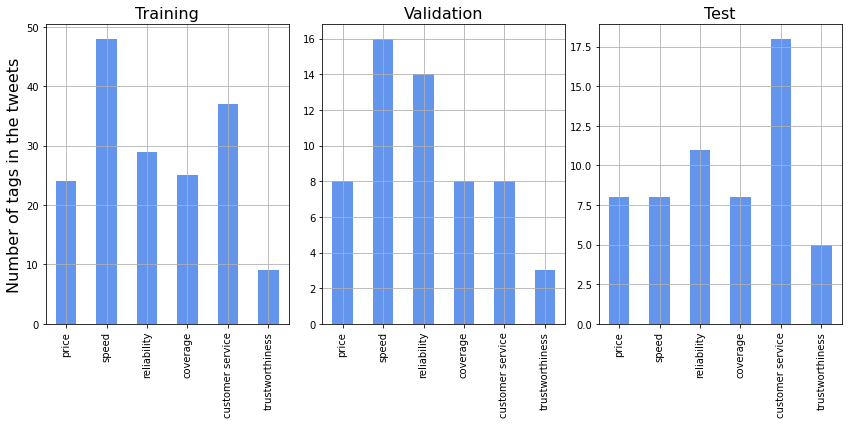

In [241]:
df_sets = [('Training',train_df),('Validation', val_df),('Test',test_df)]
    
plt.figure(figsize = (12,6))
for idx,df in enumerate(df_sets):
    
    plt.subplot(1,3,idx+1)
    plt.tight_layout()

    with plt.style.context(['notebook','no-latex','grid']):
        
        plt.title(df[0])
        df[1][ASPECTS].sum().plot(kind = "bar", color = 'cornflowerblue')
        plt.xticks(rotation=90)
        
        if idx == 0:
            plt.ylabel('Number of tags in the tweets', fontsize=16)
        
    
plt.show()

In [262]:
#Make a copy of the training set for oversampling
train_oversampled = train_df.copy()

### a. Oversample minority classes
**Note:** I had individually run it and know how the distributions turn out. The function below was done to condense the oversampling and save space in the notebook

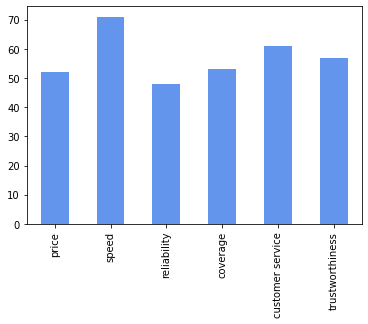

In [263]:
for aspect in ['trustworthiness', 'price', 'coverage', 'reliability']:
    
    not_aspect = train_oversampled.query(f" {aspect} == 0 ")
    aspect_tweets = train_oversampled.query(f" {aspect} == 1 ")

    #Oversample aspect tweets to size of class with maximum number of observations
    #and create new training dataset
    train_oversampled = pd.concat([
      not_aspect,
      aspect_tweets .sample(max(train_df[ASPECTS].sum().tolist()), replace=True)
    ])
    
#Plot new distribution
train_oversampled[ASPECTS].sum().plot(kind = "bar", color = 'cornflowerblue')
plt.show()

### b. Oversample tweets with no aspects

In [292]:
#Get rows with atleast one aspect tagged and rows with no aspect tagged
oversampled_aspects_tagged = train_oversampled[train_oversampled[ASPECTS].sum(axis=1) > 0]
oversampled_no_aspects = train_oversampled[train_oversampled[ASPECTS].sum(axis=1) == 0]

#Oversample the rows with no tagged aspects and then shuffle the dataframe
train_oversampled = pd.concat([
  oversampled_aspects_tagged,
  oversampled_no_aspects.sample(len(oversampled_aspects_tagged), replace=True)
]).sample(frac=1)

#Check that the counts are balanced now
print(f"No aspects count: {len(train_oversampled[train_oversampled[ASPECTS].sum(axis=1) == 0])}.",
      f"Aspects count: {len(train_oversampled[train_oversampled[ASPECTS].sum(axis=1) > 0])}")

print(f"Train size: {train_oversampled.shape}")

No aspects count: 242. Aspects count: 242
Train size: (484, 8)


### d. Setup the data module with the oversample training set

In [293]:
#Instantiate and set up the data_module
data_module2 = PyTorchDataModule(train_oversampled,val_df,test_df,TOKENIZER, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE)
data_module2.setup()

### e. Define the model

In [298]:
class ISP_TweetAspectClassifier3(pl.LightningModule):
    
    #Set the aspect classifier
    def __init__(self, n_classes=6, n_training_steps=None, n_warmup_steps=None, lr=2e-5):
        
        super().__init__()
        self.lr = lr
        self.n_classes = n_classes
        self.n_warmup_steps = n_warmup_steps
        self.n_training_steps = n_training_steps
        self.bert = BERTWEET_MODEL
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
        self.criterion = torch.nn.BCELoss()
        
    def forward(self, input_ids, attention_mask, labels = None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        
        loss = 0
        
        if labels is not None:
            loss = self.criterion(output, labels)
            
        return loss, output
    
    def training_step(self, batch, batch_idx):
        
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": outputs.detach(), "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask,labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def training_epoch_end(self, outputs):
            
        #List to store the true labels and the model's predictions
        labels = []
        predictions = []
        
        #Iterate through all the outputs and get the true vs. predicted label
        for output in outputs:
            
            for label in output["labels"].detach().cpu():
                labels.append(label)
            for pred in output["predictions"].detach().cpu():
                predictions.append(pred)
        
        #Stack the tensors
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        
        #Record the AUROC for each aspect after each training epoch
        for idx, name in enumerate(ASPECTS):
            metric = AUROC()
            class_roc_auc = metric(predictions[:,idx], labels[:,idx])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
        
        #Calculate the overall AUROC - not sure about this computation
        micro_auroc_setup = AUROC(num_classes = self.n_classes, pos_label = 1, average='micro')
        micro_auroc = micro_auroc_setup(predictions, labels)
        self.logger.experiment.add_scalar(f"micro_auroc", micro_auroc, self.current_epoch)
   
    
    def configure_optimizers(self):
        
        optimizer = AdamW(self.parameters(), lr = self.lr)
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps)
        
          
        return {'optimizer': optimizer, 'lr_scheduler':{'scheduler':scheduler,'interval':'step'}}
    

In [299]:
#Define variables
N_EPOCHS = 20
STEPS_PER_EPOCH =len(train_df)//TRAIN_BATCH_SIZE
TOTAL_TRAIN_STEPS = STEPS_PER_EPOCH * N_EPOCHS
N_WARMUP_STEPS = TOTAL_TRAIN_STEPS // 4

#Instantiate the classifier model
model3 = ISP_TweetAspectClassifier3(n_training_steps = TOTAL_TRAIN_STEPS,
                                   n_warmup_steps   = N_WARMUP_STEPS)

### d. Training

In [300]:
#Setup callback to perform saves during training
checkpoint_callback3 = ModelCheckpoint(
  dirpath    = "../models/absa-aspect-extraction/bertweet_oversampled",
  filename   = "ae-{epoch:02d}-{val_loss:.2f}",
  save_top_k = 3, #Save the top 3 models
  verbose    = True,
  monitor    = "val_loss",
  mode       = "min" #Minimize val loss
)

#Log progress in Tensorboard
logger3 = TensorBoardLogger("../models/absa-aspect-extraction/bertweet_oversampled/lightning_logs", name = "isp-tweets")

In [301]:
trainer3 = pl.Trainer(
    #gpus                       = 1,
    logger                      = logger3,
    log_every_n_steps           = 10,
    callbacks                   = [checkpoint_callback3],
    max_epochs                  =  N_EPOCHS,
    progress_bar_refresh_rate   =  30
)

trainer3.fit(model3, data_module2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type         | Params
--------------------------------------------
0 | bert       | RobertaModel | 134 M 
1 | classifier | Linear       | 4.6 K 
2 | criterion  | BCELoss      | 0     
--------------------------------------------
4.6 K     Trainable params
134 M     Non-trainable params
134 M     Total params
539.618   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Global seed set to 123


Training: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 0, global step 15: val_loss reached 0.69919 (best 0.69919), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=00-val_loss=0.70.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usin

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 1, global step 31: val_loss reached 0.68419 (best 0.68419), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=01-val_loss=0.68.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usin

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 2, global step 47: val_loss reached 0.66056 (best 0.66056), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=02-val_loss=0.66.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usin

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 3, global step 63: val_loss reached 0.63692 (best 0.63692), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=03-val_loss=0.64.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usin

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 4, global step 79: val_loss reached 0.61751 (best 0.61751), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=04-val_loss=0.62.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usin

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 5, global step 95: val_loss reached 0.60191 (best 0.60191), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=05-val_loss=0.60.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usin

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 6, global step 111: val_loss reached 0.58949 (best 0.58949), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=06-val_loss=0.59.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usi

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 7, global step 127: val_loss reached 0.58010 (best 0.58010), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=07-val_loss=0.58.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usi

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 8, global step 143: val_loss reached 0.57337 (best 0.57337), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=08-val_loss=0.57.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usi

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 9, global step 159: val_loss reached 0.56911 (best 0.56911), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=09-val_loss=0.57.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when usi

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 10, global step 175: val_loss reached 0.56726 (best 0.56726), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=10-val_loss=0.57.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when us

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 11, global step 191: val_loss reached 0.56717 (best 0.56717), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=11-val_loss=0.57.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when us

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 12, global step 207: val_loss reached 0.56717 (best 0.56717), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=12-val_loss=0.57.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when us

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 13, global step 223: val_loss reached 0.56717 (best 0.56717), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bertweet_oversampled/ae-epoch=13-val_loss=0.57.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when us

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 14, global step 239: val_loss was not in top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 15, global step 255: val_loss was not in top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 16, global step 271: val_loss was not in top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 17, global step 287: val_loss was not in top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 18, global step 303: val_loss was not in top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 19, global step 319: val_loss was not in top 3


Already very skeptical about this model since the loss did not decrease significantly

### e. Model Evaluation

In [302]:
#Evaluate the model's performance on the test dataset
trainer3.test(model3,data_module2)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5572946667671204}
--------------------------------------------------------------------------------


[{'test_loss': 0.5572946667671204}]

In [304]:
# Visualize the logs using tensorboard.
%load_ext tensorboard
%tensorboard --logdir ../models/absa-aspect-extraction/bertweet_oversampled/lightning_logs/
#%reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 53019), started 0:00:22 ago. (Use '!kill 53019' to kill it.)

Micro AUROC (around 0.5) is bad. Suggests random guessing at best – i.e. poor classifier

#### (i) Evaluate model performance on a generated example

In [305]:
#Load the best model based on validation loss
trained_model3 = ISP_TweetAspectClassifier3.load_from_checkpoint(
    trainer3.checkpoint_callback.best_model_path,
    n_classes=len(ASPECTS),
    
)

In [306]:
#Put model into evaluation mode
trained_model3.eval()
trained_model3.freeze()

In [307]:
test_comment = "The internet is so slow and it's so expensive"

encoding = TOKENIZER.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=TOKENIZER.model_max_length,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model3(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(ASPECTS, test_prediction):
    print(f"{label}: {prediction}")

price: 0.4770582616329193
speed: 0.4313480257987976
reliability: 0.41877180337905884
coverage: 0.36569344997406006
customer service: 0.41532450914382935
trustworthiness: 0.34830161929130554


Doesn't seem to do a good job distinguishing the different aspects for this case. Although the values are finally higher! Real difference seems to have been increased training sample size. Or increased samples for the different labels

#### (ii) Evaluate model performance on the validation set

In [308]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model3 = trained_model3.to(device)

#Prepare the validation set
val_dataset = Generate_PyTorch_Dataset(
    val_df,
    TOKENIZER,
)

#Lists to store the model predictions and the true labels
model_preds = []
true_labels = []

for item in tqdm(val_dataset):
    _, pred = trained_model3(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    model_preds.append(pred.flatten())
    true_labels.append(item["labels"].int())

model_preds = torch.stack(model_preds).detach().cpu()
true_labels = torch.stack(true_labels).detach().cpu()

  0%|          | 0/101 [00:00<?, ?it/s]

In [319]:
#Compute the accuracy on the validation set
acc_metric = Accuracy()
acc_metric(model_preds, true_labels)

tensor(0.9026)

We get a fairly high accuracy on the validation set. However, we note that the dataset is quite imbalanced. So it would be important to also check the model's performance on the different aspects (remember: trustworthiness had very few samples)

In [310]:
auroc_metric = AUROC(pos_label=1)
print("AUROC per tag")
for i, name in enumerate(ASPECTS):
    tag_auroc = auroc_metric(model_preds[:, i], true_labels[:, i])
    print(f"{name}: {tag_auroc}")

AUROC per tag
price: 0.6263440847396851
speed: 0.5874999165534973
reliability: 0.47454842925071716
coverage: 0.4448924958705902
customer service: 0.8682795763015747
trustworthiness: 0.5748299956321716


/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Classification Report

In [326]:
y_pred = model_preds.numpy()
y_true = true_labels.numpy()

y_pred = np.where(y_pred > 0.43, 1, 0)

print(classification_report(
  y_true,
  y_pred,
  target_names=ASPECTS,
  zero_division=0
))

                  precision    recall  f1-score   support

           price       0.08      1.00      0.15         8
           speed       0.13      0.19      0.15        16
     reliability       0.11      0.14      0.12        14
        coverage       0.09      0.12      0.11         8
customer service       0.36      0.62      0.45         8
 trustworthiness       0.00      0.00      0.00         3

       micro avg       0.11      0.33      0.17        57
       macro avg       0.13      0.35      0.16        57
    weighted avg       0.14      0.33      0.17        57
     samples avg       0.08      0.17      0.10        57



Still not good enough. I think we need a lot more data to start seeing promising results